In [1]:
import cv2
from matplotlib import pyplot as plt
import math
import numpy as np
import glob

In [2]:
def display_image(img, title="image"):
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [2]:
def merge_boxes(boxes, distance_threshold=10):
    """
    A function that merges bounding boxes that are `distance_threshold` away from each other.
    """
    merged_boxes = []
    for box in boxes:
        merged = False
        for i in range(len(merged_boxes)):
            x1,y1,w1,h1 = merged_boxes[i]
            x2,y2,w2,h2 = box
            if (abs(x1-x2) < distance_threshold and abs(y1-y2) < distance_threshold):
                new_x = min(x1, x2)
                new_y = min(y1, y2)
                new_w = max(x1+w1, x2+w2) - new_x
                new_h = max(y1+h1, y2+h2) - new_y
                merged_boxes[i] = (new_x, new_y, new_w, new_h)
                merged = True
                break
        if not merged:
            merged_boxes.append(box)

    return merged_boxes

In [3]:
def calculate_huMoments(image):
    """
    A helper function to calculate the huMoments.
    """
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments).flatten()
    #Log transform the HuMoments
    for i in range(0,7):
        if hu_moments[i] == 0:
            hu_moments[i] = 0
        else:
            hu_moments[i] = -1* math.copysign(1.0, hu_moments[i]) * math.log10(abs(hu_moments[i]))
    return hu_moments


In [4]:
def compare_hu_moments(hu1, hu2):
    """
    A simple function that returns the norm of two hu moments to compare them.
    """
    return np.linalg.norm(hu1 - hu2)

In [5]:
#Getting HuMoments of all images

vowel_huMoments = {}
vow_moments = []
images = glob.glob("vow*.png")
images.sort()

vowels = ["u", "o", "i", "e", "a"]

for vowel, image in zip(vowels, images):
    print("Calculating moments for ", image)
    im = cv2.imread(image)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inverted = cv2.bitwise_not(binary)

    hu_moments = calculate_huMoments(inverted)
    vowel_huMoments[vowel] = hu_moments

print("Stored Hu Moments for each vowel:")
for vowel, moments in vowel_huMoments.items():
    print(f"{vowel}: {moments}")

Calculating moments for  vow_0.png
Calculating moments for  vow_1.png
Calculating moments for  vow_2.png
Calculating moments for  vow_3.png
Calculating moments for  vow_4.png
Stored Hu Moments for each vowel:
u: [  2.72188446   8.18757784   9.72429366   9.688771   -19.39955567
  14.41302354 -20.25148864]
o: [ 2.48906438  5.00107858  8.53739319  8.53739319 17.07478639 11.03793249
  0.        ]
i: [  2.77711869   7.62039712  13.77135519  14.68900658  29.04130549
 -18.50974851 -29.10237975]
e: [  2.85037687   7.48618296  10.22105218  10.4602303  -21.51581484
 -14.49127098  20.80909521]
a: [  2.85719913   7.11307226   9.81369176  10.64136078 -20.88589308
 -14.26288285 -21.43041036]


In [37]:
new_glyph = cv2.imread("new_glyph.jpg")
gray = cv2.cvtColor(new_glyph, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
inverted = cv2.bitwise_not(binary)

new_huMoments = calculate_huMoments(inverted)

best_match = None
min_distance = float('inf')

for vowel, hu_moments in vowel_huMoments.items():
    distance = compare_hu_moments(new_huMoments, hu_moments)
    if distance < min_distance:
        min_distance = distance
        best_match = vowel

print(f"The new glyph is closest to the vowel: {best_match}")

The new glyph is closest to the vowel: a


---

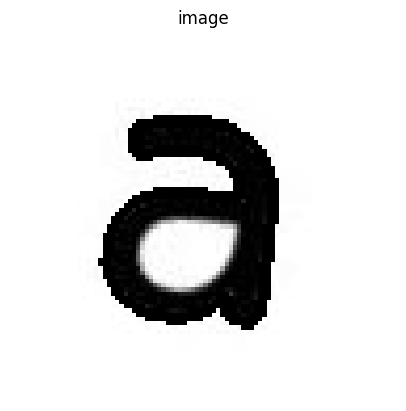

The distance between u and the glyph is 0.5985650517326216.
The distance between o and the glyph is 0.21942349246277737.
The distance between i and the glyph is 1.456269246009837.
The distance between e and the glyph is 0.4531127219337774.
The distance between a and the glyph is 0.9163238623603005.

The new glyph is closest to the vowel: o.


In [110]:
#Just found out opencv has a thing called matchshapes.

vowel_contours = {}

for vowel, image in zip(vowels, images):
    im = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(im, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, 2, 1)
    vowel_contours[vowel] = contours

newim = cv2.imread("new_glyph.jpg", cv2.IMREAD_GRAYSCALE)
_, new_thresh = cv2.threshold(newim, 127,255,0)
new_contours, _ = cv2.findContours(new_thresh,2,1)
new_cnt = new_contours[2]

#print(new_contours)

contour_img = newim.copy()
cv2.drawContours(contour_img, new_contours[2], -1, (0,255,0), 2)
display_image(contour_img)

best_match = None
min_distance = float('inf')

for vowel, contour, in vowel_contours.items():
    cnt = contour[0]
    ret = cv2.matchShapes(new_cnt, cnt,1,0.0)
    print(f"The distance between {vowel} and the glyph is {ret}.")
    if ret < min_distance:
        min_distance = ret
        best_match = vowel

print("")
print(f"The new glyph is closest to the vowel: {best_match}.")

#Not very reliable, unfortunately.